<a href="https://colab.research.google.com/github/ritwiks9635/New_Project_Ideas/blob/main/Vit_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
https://www.kaggle.com/datasets/ denizkavi1/brain-tumor

# **VISION TRANSFORMER**

In [2]:
import shutil

# Path of the file
filename = "/content/https:/www.kaggle.com/datasets/denizkavi1/brain-tumor/brain-tumor.zip"
# Target directory
extract_dir = "brain_tumors/"

# Unzip the file
shutil.unpack_archive(filename, extract_dir)
#cloude

In [3]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 5.5 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
import glob, random, os, warnings
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print('TensorFlow Version ' + tf.__version__)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow Version 2.14.0


In [ ]:
def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()

In [5]:
img_size = 224
batch_size = 16
n_classes = 3
epochs = 30

data_dir = "/content/brain_tumors"

classes = {1 : "Meningioma",
           2 : "Glioma",
           3 : "Pituitary Tumor"}

In [6]:
def data_augmentation(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)

    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    if p_spatial > .75:
        image = tf.image.transpose(image)

    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º

    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
    return image

In [7]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255.0,
    samplewise_center = True,
    samplewise_std_normalization = True,
    validation_split = 0.2,
    preprocessing_function = data_augmentation)

In [8]:
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    seed = 1,
    color_mode = "rgb",
    shuffle = True,
    class_mode = "categorical",
    subset = "training")


val_gen = datagen.flow_from_directory(
    data_dir,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    seed = 1,
    color_mode = "rgb",
    shuffle = True,
    class_mode = "categorical",
    subset = "validation")

Found 2452 images belonging to 3 classes.
Found 612 images belonging to 3 classes.


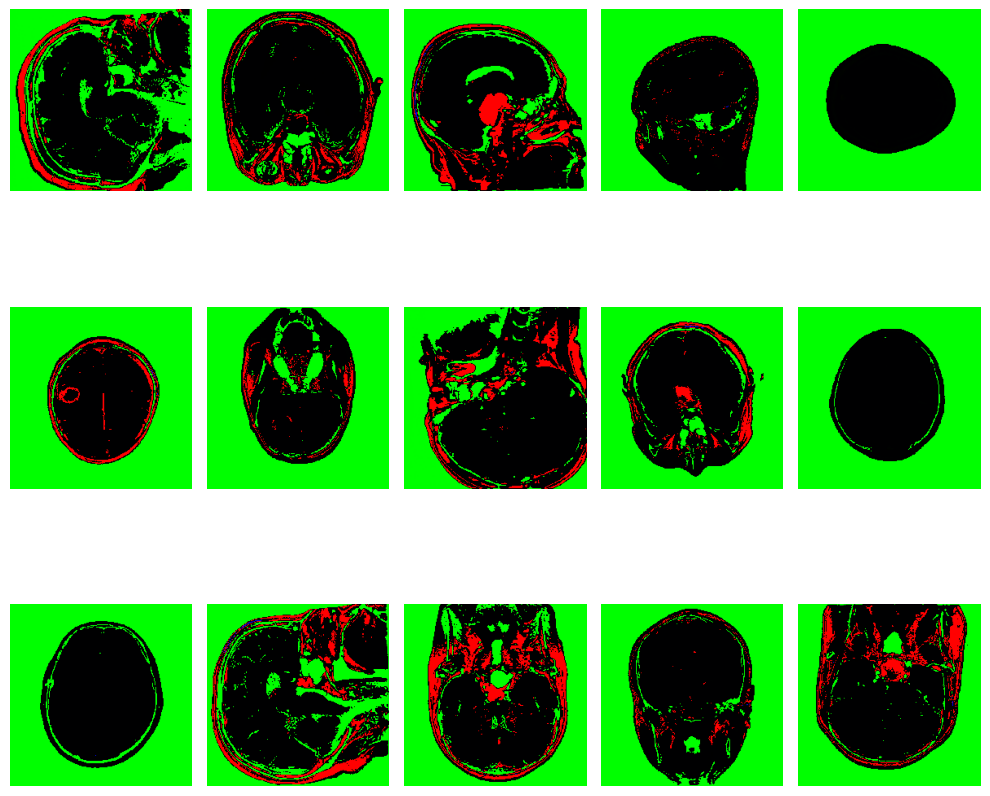

In [9]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(img_size, img_size, 3).astype("uint8"))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
!pip install vit_keras

In [11]:
from vit_keras import vit

In [12]:
vit_model = vit.vit_b16(
    image_size = img_size,
    activation = "softmax",
    pretrained = True,
    include_top = False,
    pretrained_top = False,
    classes = 5 )

347502902/347502902 [==============================] - 2s 0us/step


In [13]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


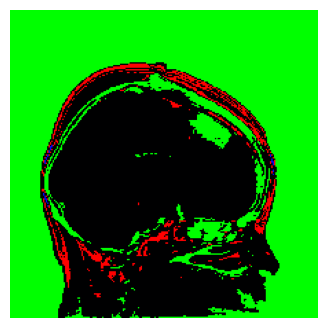

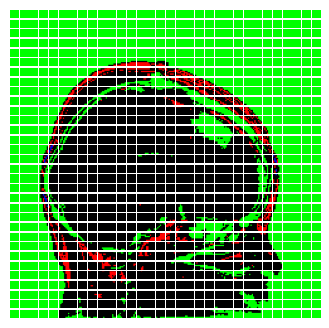

In [14]:
plt.figure(figsize=(4, 4))
batch_size = 16
patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (img_size // patch_size) ** 2

x = train_gen.next()
image = x[0][0]

plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (img_size, img_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {img_size} X {img_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

In [15]:
model = tf.keras.Sequential([
    vit_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(128, activation = tfa.activations.gelu),
    layers.BatchNormalization(),
    layers.Dense(64, activation = tfa.activations.gelu),
    layers.Dense(32, activation = tfa.activations.gelu),
    layers.Dense(3, activation = "softmax"),
    ], name = "vision_transformer")

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 64)         

In [16]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
   metrics = ["accuracy"])

In [17]:
steps_per_epoch = train_gen.n // train_gen.batch_size
validation_steps = val_gen.n // val_gen.batch_size

In [ ]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose=1)
history = model.fit(train_gen,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_gen,
    validation_steps = validation_steps,
    epochs = epochs,
    callbacks = [EarlyStopping])